In [1]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
from scipy import stats
import cv2
from pyspark import SparkContext, SparkConf
import skimage
from pathlib import Path

def mean2(x):
    y = np.sum(x) / np.size(x);
    return y
def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r
from copy import deepcopy
from skimage.filters import threshold_otsu,threshold_li
import glob
from IPython.display import clear_output
import scipy.io as spio
import matplotlib.ticker as ticker
import pims
import fnmatch
from skimage import io
import os.path, time

In [2]:
expdir='Y:\\user\\tdanko\\Imaging\\1_ECM\\Live Culture\\Cytation_biospa\\20190307_TNR550_BicTTX\\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\\190307_133419_Plate 1\\'

In [3]:
results={"filename":[],
         "exp name":[],
        "condition":[],
        "namestem before channel":[],
         "namestem after channel":[],
        "timepoint":[],
        "analyse":[]}

path = os.path.dirname(expdir)  
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))      
for i in range(0,len(filelist)):
    if ("montage" in str(filelist[i]))==False:
        
        if filelist[i].endswith(".tif"): 
            results["filename"].append(filelist[i])
            results["analyse"].append(False)
            results["exp name"].append(filelist[i][:-12].split('\\')[-2])
            results["namestem before channel"].append('\\'.join(filelist[i].split('\\')[:-1])+'\\'+'_'.join(filelist[i].split('\\')[-1].split('_')[:-4]))
            results["namestem after channel"].append('_'.join(filelist[i].split('\\')[-1].split('_')[-3:-1]))
            results["timepoint"].append(filelist[i][-7:-4])
            if len(fnmatch.filter([filelist[i]],r'*A[0-9]_*'))>0:
                results["condition"].append("Unblocked")
            elif len(fnmatch.filter([filelist[i]],r'*B[0-9]_*'))>0:
                results["condition"].append("Blocked")
            elif len(fnmatch.filter([filelist[i]],r'*C[0-9]_*'))>0:
                results["condition"].append("Blocked + Bic")
            elif len(fnmatch.filter([filelist[i]],r'*D[0-9]_*'))>0:
                results["condition"].append("Blocked + TTX")
            
            else:
                results["condition"].append('Unspecified')

In [4]:
df=pd.DataFrame(results)

In [5]:
df["condition"].unique()

array(['Unblocked', 'Blocked', 'Blocked + Bic', 'Blocked + TTX'],
      dtype=object)

## Throw out images with no cells

In [11]:
indexes=df.loc[df["filename"].str.contains("Phase Contrast_001")].index

In [14]:
len(indexes)

384

In [18]:
import ipywidgets as widgets
from ipywidgets import interact



#load first image

ecm_image_name=df["filename"][indexes[0]]
ecm_image = io.imread(ecm_image_name)


def f(Threshold,Image_no):
    
    ii=Image_no
    ecm_image_name=df["filename"][indexes[ii]]
    ecm_image = io.imread(ecm_image_name)

    if Threshold=="Keep":
        df["analyse"][indexes[ii]]=True
    
    fig=plt.figure(figsize=(10,10))
    plt.imshow(ecm_image,cmap='gray')
    plt.title(ecm_image_name)
    

#widgets
Threshold=widgets.Dropdown(options=["Keep","Toss"])
Image_no=widgets.IntText(min=0,max=len(indexes),value=0)

w=interact(f,Threshold=Threshold,
           Image_no=Image_no)

interactive(children=(Dropdown(description='Threshold', options=('Keep', 'Toss'), value='Keep'), IntText(value=0, description='Image_no'), Output()), _dom_classes=('widget-interact',))

In [23]:
indexes=df.loc[df["filename"].str.contains("Phase Contrast_001")].index
timepoints=df["timepoint"].unique()

intensities={"namestem":[],
            "condition":[],
            "intensities vector":[],
            "intensities vector bgsub":[]}
counter=0
for i in indexes:
    counter+=1
    print(str(counter)+' out of ' +str(len(indexes)))
    name=df["filename"][i]
    print(name)
    namestem='\\'.join(name.split('\\')[:-1])+'\\'+'_'.join(name.split('\\')[-1].split('_')[:-4])+'_2_'+name.split('_')[-3]+'_RFP_'
    print(namestem)
    intensities["namestem"].append(namestem)
    intensities["condition"].append(df["condition"][i])
    intensities_vect=[]
    intensities_vect_bgsubtracted=[]
    if df["analyse"][i]==True:
        for time in timepoints:
            print(time)
            fullname=namestem+time+'.tif'
            #read image
            ecm_image = io.imread(fullname)
            intensities_vect.append(ecm_image.mean())
            #bg
            bg=np.mean(ndi.median_filter(ecm_image,size=5))+0*np.std(ndi.median_filter(ecm_image,size=5))
            ecm_bgreduced=np.subtract(ecm_image,bg)
            ecm_bgreduced[ecm_bgreduced<0]=0
            intensities_vect_bgsubtracted.append(ecm_bgreduced.mean())
        intensities["intensities vector"].append(intensities_vect)
        intensities["intensities vector bgsub"].append(intensities_vect_bgsubtracted)
    else:
        intensities["intensities vector"].append(np.nan)
        intensities["intensities vector bgsub"].append(np.nan) 

1 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\A1_02_1_10_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\A1_02_2_10_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
2 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\A1_02_1_11_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\A1_02_2_11_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
01

002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
17 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\A2_02_1_10_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\A2_02_2_10_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
18 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\A2_02_1_11_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation

029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
33 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\A3_02_1_10_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\A3_02_2_10_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
34 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\A3_02_1_11_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\

002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
52 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\A4_02_1_12_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\A4_02_2_12_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
53 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\A4_02_1_13_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation

002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
75 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\A5_02_1_4_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\A5_02_2_4_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
76 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\A5_02_1_5_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_bi

002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
94 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\A6_02_1_7_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\A6_02_2_7_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
95 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\A6_02_1_8_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_bi

002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
114 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\B2_02_1_11_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\B2_02_2_11_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
115 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\B2_02_1_12_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytati

002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
129 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\B3_02_1_10_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\B3_02_2_10_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
130 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\B3_02_1_1_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytatio

002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
145 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\B4_02_1_10_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\B4_02_2_10_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
146 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\B4_02_1_1_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytatio

002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
163 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\B5_02_1_12_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\B5_02_2_12_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
164 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\B5_02_1_13_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytati

002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
194 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\C1_02_1_11_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\C1_02_2_11_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
195 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\C1_02_1_12_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytati

002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
211 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\C2_02_1_12_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\C2_02_2_12_RFP_
212 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\C2_02_1_13_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\C2_02_2_13_RFP_
213 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\C

019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
229 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\C3_02_1_13_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\C3_02_2_13_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
230 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\C3_02_1_14_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_0

042
043
044
045
046
245 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\C4_02_1_14_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\C4_02_2_14_RFP_
246 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\C4_02_1_15_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\C4_02_2_15_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
247 out of 384
Y:\user\tdanko\Imag

002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
274 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\C6_02_1_11_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\C6_02_2_11_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
275 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\C6_02_1_12_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytati

002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
292 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\D1_02_1_13_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\D1_02_2_13_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
293 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\D1_02_1_14_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytati

002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
312 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\D2_02_1_16_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\D2_02_2_16_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
313 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\D2_02_1_2_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytatio

025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
328 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\D3_02_1_1_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\D3_02_2_1_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
329 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\D3_02_1_2_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_

002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
344 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\D4_02_1_1_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\D4_02_2_1_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
345 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\D4_02_1_2_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_

025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
360 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\D5_02_1_1_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\D5_02_2_1_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
361 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\D5_02_1_2_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_

002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
376 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\D6_02_1_1_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\D6_02_2_1_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
377 out of 384
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_biospa\20190307_TNR550_BicTTX\190307_133419_20190306_Tal_TNR550_07-Mar-2019 13-30-40\190307_133419_Plate 1\D6_02_1_2_Phase Contrast_001.tif
Y:\user\tdanko\Imaging\1_ECM\Live Culture\Cytation_

In [24]:
for key in intensities.keys():
    print(key)
    print(len(intensities[key]))

namestem
384
condition
384
intensities vector
384
intensities vector bgsub
384


In [88]:
dfint=pd.DataFrame(intensities)

In [89]:
dfint.columns

Index(['namestem', 'condition', 'intensities vector',
       'intensities vector bgsub'],
      dtype='object')

In [91]:
for i in range(0,len(dfint)):
    if type(dfint["intensities vector bgsub"][i])==float:
        #print('true')
        dfint["intensities vector"][i]=np.repeat(np.nan,46)
        dfint["intensities vector bgsub"][i]=np.repeat(np.nan,46)

In [93]:
dfint.to_pickle(expdir+'20191003_longterm_intensities.pkl')

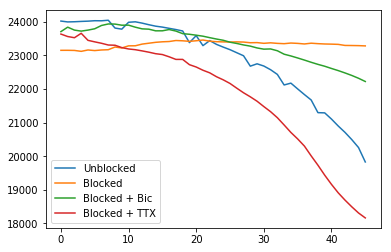

In [94]:
toplot="intensities vector"
conditioni=dfint["condition"].unique()
for condition in dfint["condition"].unique():
    
    df2plot=dfint[dfint["condition"]==condition]
    plt.plot(np.nanmean(df2plot[toplot].tolist(),axis=0))
    plt.legend(conditioni)